In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tifffile as tf
from scipy.ndimage import fourier_shift
from scipy.signal import fftconvolve
import suite2p
from PIL import Image

import sys  
sys.path.append("..")
from utils_image import compute_zpos_sp

In [2]:
def convertto255(img):
    img = img.astype(np.float32)
    #normalize to 0-1 according to min max
    img = (img - np.min(img))/(np.max(img) - np.min(img))
    img = img*255
    img = img.astype(np.uint8)
    return img

In [3]:
def calculate_phase_correlation_map(image1, image2):
    # Perform Fourier shift on image2
    shift = np.fft.ifftshift(np.array(np.unravel_index(np.argmax(np.abs(fftconvolve(image1, np.conj(image2), mode='same')), axis=None), image1.shape)))
    shifted_fft = fourier_shift(np.fft.fftn(image2), shift)
    shifted_image = np.fft.ifftn(shifted_fft).real

    # Compute the cross-correlation
    cross_correlation = np.fft.ifft2(np.fft.fft2(image1) * np.fft.fft2(shifted_image).conj())
    
    #get the real part and normalize the cross-correlation and return
    return cross_correlation.real/cross_correlation.real.max()

0 planes, 0/1 frames, 0.06 sec.


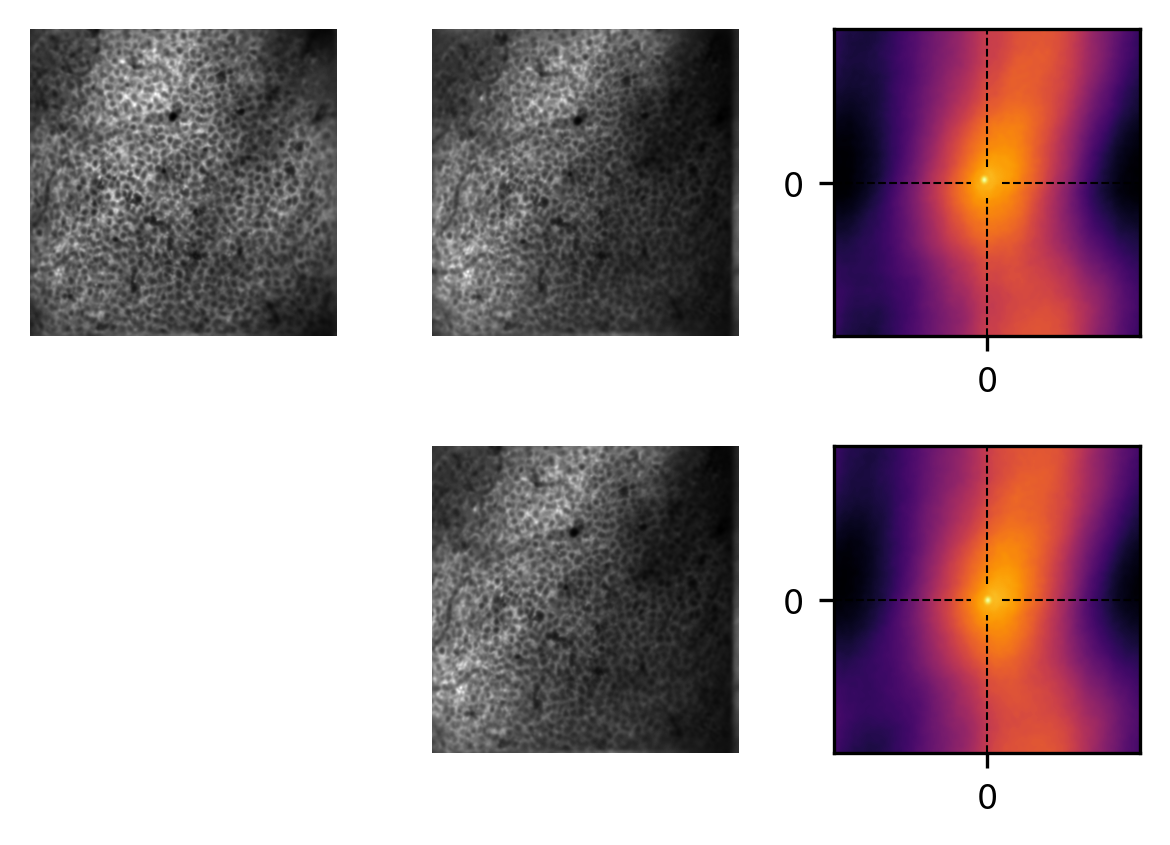

In [7]:
#day 183_03082023
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
ops_1 =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops_1 = ops_1.item()

#day 
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_04082023"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
ops_2 =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops_2 = ops_2.item()

meanImg_1 = ops_1['meanImg']
meanImg_2 = ops_2['meanImg']

# meanImg_1 = ops_1['max_proj']
# meanImg_2 = ops_2['max_proj']

#pad the smaller one with zeros
constant_values = np.mean(meanImg_1)
if meanImg_1.shape[0] > meanImg_2.shape[0]:
    #pad meanImg_2 in both width and height
    pad_width = int((meanImg_1.shape[0] - meanImg_2.shape[0])/2)
    meanImg_2_pad = np.pad(meanImg_2, ((pad_width, pad_width), (pad_width, pad_width)), 'constant', constant_values=constant_values)
    meanImg_1_pad = meanImg_1.copy()
elif meanImg_1.shape[0] < meanImg_2.shape[0]:
    #pad meanImg_1 in both width and height
    pad_width = int((meanImg_2.shape[0] - meanImg_1.shape[0])/2)
    meanImg_1_pad = np.pad(meanImg_1, ((pad_width, pad_width), (pad_width, pad_width)), 'constant', constant_values=constant_values)
    meanImg_2_pad = meanImg_2.copy()


#show mean images in gridspec
labelsize = 10
ticksize = 8
fig = plt.figure(figsize=(4,3), dpi=300)

gs = GridSpec(2, 3, height_ratios=[1,1], width_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0, 0])

ax0.imshow(meanImg_1, cmap='gray')
#ticsk and axis off
ax0.set_xticks([]); ax0.set_yticks([])
ax0.axis('off')


ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(meanImg_2, cmap='gray')
#ticsk and axis off
ax1.set_xticks([]); ax1.set_yticks([])
ax1.axis('off')


#ax2
ax2 = fig.add_subplot(gs[0, 2])
#for meanImg_1 and meanImg_2, center pad the smaller one with zeros to make them the same size
#and then calculate the phase correlation map

#perform phase correlation map of meanImg_1 and meanImg_2
correlation_map = calculate_phase_correlation_map(meanImg_1_pad, meanImg_2_pad)

#show the correlation map
ax2.imshow(correlation_map, cmap='inferno')

#add x=half width and y=half height reference lines as dashed black lines using axhline and axvline
half_width = correlation_map.shape[1]/2
half_height = correlation_map.shape[0]/2

ax2.axhline(y=half_height, xmin=0, xmax=0.45, color='black', linestyle='--', linewidth=0.5)
ax2.axhline(y=half_height, xmin=0.55, xmax=1, color='black', linestyle='--', linewidth=0.5)
ax2.axvline(x=half_width, ymin=0, ymax=0.45, color='black', linestyle='--', linewidth=0.5)
ax2.axvline(x=half_width, ymin=0.55, ymax=1, color='black', linestyle='--', linewidth=0.5)

ax2.set_xticks([half_width]); ax2.set_xticklabels(['0'], size=ticksize)
ax2.set_yticks([half_height]); ax2.set_yticklabels(['0'], size=ticksize)

#######################################
ops = suite2p.default_ops()
#add new dimension at the beginning
meanImg_1_pad = np.expand_dims(meanImg_1_pad, axis=0)
meanImg_2_pad = np.expand_dims(meanImg_2_pad, axis=0)
ymax, xmax, corrMatrix = compute_zpos_sp(meanImg_2_pad, meanImg_1_pad, ops)

#I want to shift meanImg_2 according to the ymax and xmax
#to align meanImg_2 with meanImg_1, and crop the meanImg_2 to the same size as meanImg_1

#shift meanImg_2
meanImg_2_shifted = np.roll(meanImg_2, (ymax[0][0], xmax[0][0]), axis=(0,1))

#center crop meanImg_2 to the same size as meanImg_1 using PIL
left = int((meanImg_2_shifted.shape[0] - meanImg_1.shape[0])/2)
top = int((meanImg_2_shifted.shape[1] - meanImg_1.shape[1])/2)
right = int((meanImg_2_shifted.shape[0] + meanImg_1.shape[0])/2)
bottom = int((meanImg_2_shifted.shape[1] + meanImg_1.shape[1])/2)
#transform to PIL image
meanImg_2_shifted = Image.fromarray(meanImg_2_shifted)
#crop
meanImg_2_shifted = meanImg_2_shifted.crop((left, top, right, bottom))
#transform back to numpy array
meanImg_2_shifted = np.array(meanImg_2_shifted)

ax3 = fig.add_subplot(gs[1, 1])

#show meanImg_2_shifted on ax3
ax3.imshow(meanImg_2_shifted, cmap='gray')
#ticsk and axis off
ax3.set_xticks([]); ax3.set_yticks([])
ax3.axis('off')


########
#perform phase correlation map of meanImg_1 and meanImg_2
correlation_map2 = calculate_phase_correlation_map(meanImg_1, meanImg_2_shifted)

ax4 = fig.add_subplot(gs[1, 2])

#show the correlation map
ax4.imshow(correlation_map2, cmap='inferno')

#add x=half width and y=half height reference lines as dashed black lines using axhline and axvline
half_width = correlation_map2.shape[1]/2
half_height = correlation_map2.shape[0]/2

ax4.axhline(y=half_height, xmin=0, xmax=0.45, color='black', linestyle='--', linewidth=0.5)
ax4.axhline(y=half_height, xmin=0.55, xmax=1, color='black', linestyle='--', linewidth=0.5)
ax4.axvline(x=half_width, ymin=0, ymax=0.45, color='black', linestyle='--', linewidth=0.5)
ax4.axvline(x=half_width, ymin=0.55, ymax=1, color='black', linestyle='--', linewidth=0.5)

ax4.set_xticks([half_width]); ax4.set_xticklabels(['0'], size=ticksize)
ax4.set_yticks([half_height]); ax4.set_yticklabels(['0'], size=ticksize)
    
plt.tight_layout()

### plot after matching the FOV of day 183_04082023

0 planes, 0/1 frames, 0.04 sec.


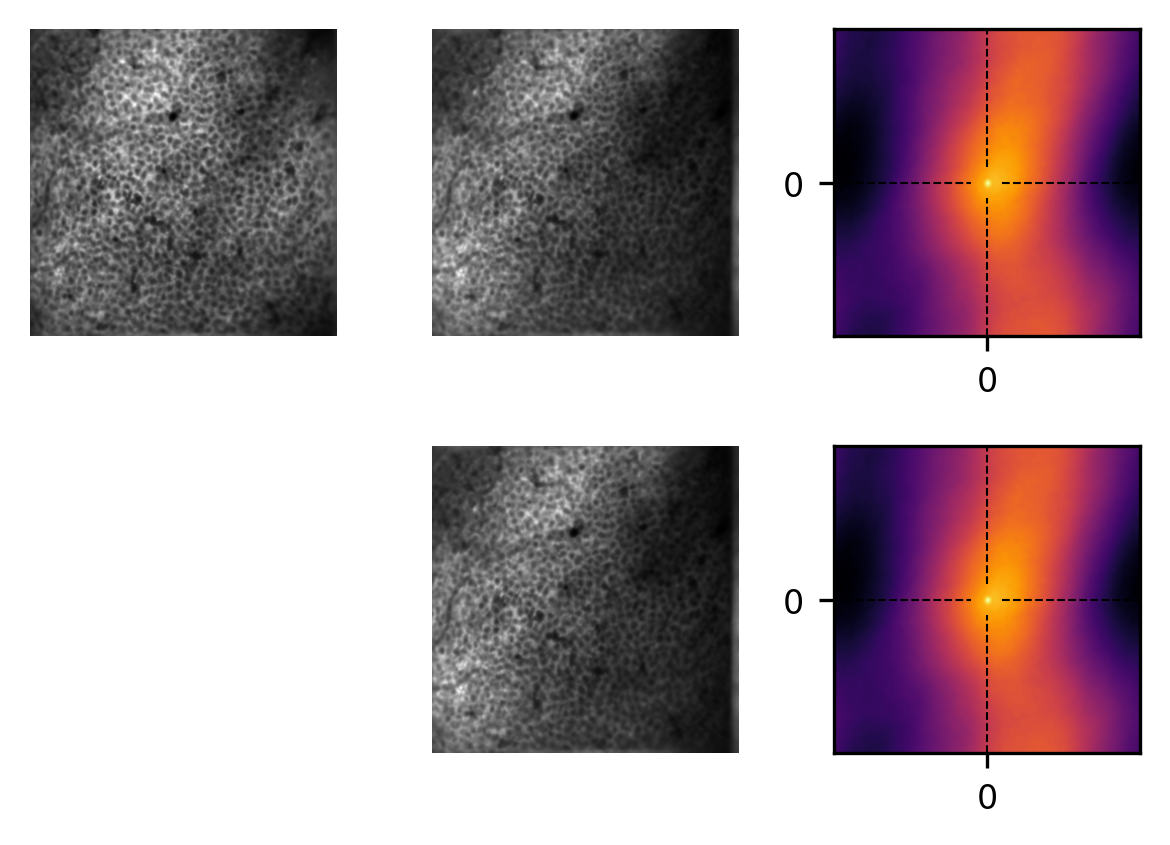

In [4]:
#day 183_03082023
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
ops_1 =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops_1 = ops_1.item()

#day 
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_04082023"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff_crossdaymatching/suite2p/plane0')
ops_2 =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops_2 = ops_2.item()

meanImg_1 = ops_1['meanImg']
meanImg_2 = ops_2['meanImg']

# meanImg_1 = ops_1['max_proj']
# meanImg_2 = ops_2['max_proj']

#pad the smaller one with zeros
constant_values = np.mean(meanImg_1)
if meanImg_1.shape[0] >= meanImg_2.shape[0]:
    #pad meanImg_2 in both width and height
    pad_width = int((meanImg_1.shape[0] - meanImg_2.shape[0])/2)
    meanImg_2_pad = np.pad(meanImg_2, ((pad_width, pad_width), (pad_width, pad_width)), 'constant', constant_values=constant_values)
    meanImg_1_pad = meanImg_1.copy()
elif meanImg_1.shape[0] < meanImg_2.shape[0]:
    #pad meanImg_1 in both width and height
    pad_width = int((meanImg_2.shape[0] - meanImg_1.shape[0])/2)
    meanImg_1_pad = np.pad(meanImg_1, ((pad_width, pad_width), (pad_width, pad_width)), 'constant', constant_values=constant_values)
    meanImg_2_pad = meanImg_2.copy()


#show mean images in gridspec
labelsize = 10
ticksize = 8
fig = plt.figure(figsize=(4,3), dpi=300)

gs = GridSpec(2, 3, height_ratios=[1,1], width_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0, 0])

ax0.imshow(meanImg_1, cmap='gray')
#ticsk and axis off
ax0.set_xticks([]); ax0.set_yticks([])
ax0.axis('off')


ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(meanImg_2, cmap='gray')
#ticsk and axis off
ax1.set_xticks([]); ax1.set_yticks([])
ax1.axis('off')


#ax2
ax2 = fig.add_subplot(gs[0, 2])
#for meanImg_1 and meanImg_2, center pad the smaller one with zeros to make them the same size
#and then calculate the phase correlation map

#perform phase correlation map of meanImg_1 and meanImg_2
correlation_map = calculate_phase_correlation_map(meanImg_1_pad, meanImg_2_pad)

#show the correlation map
ax2.imshow(correlation_map, cmap='inferno')

#add x=half width and y=half height reference lines as dashed black lines using axhline and axvline
half_width = correlation_map.shape[1]/2
half_height = correlation_map.shape[0]/2

ax2.axhline(y=half_height, xmin=0, xmax=0.45, color='black', linestyle='--', linewidth=0.5)
ax2.axhline(y=half_height, xmin=0.55, xmax=1, color='black', linestyle='--', linewidth=0.5)
ax2.axvline(x=half_width, ymin=0, ymax=0.45, color='black', linestyle='--', linewidth=0.5)
ax2.axvline(x=half_width, ymin=0.55, ymax=1, color='black', linestyle='--', linewidth=0.5)

ax2.set_xticks([half_width]); ax2.set_xticklabels(['0'], size=ticksize)
ax2.set_yticks([half_height]); ax2.set_yticklabels(['0'], size=ticksize)

#######################################
ops = suite2p.default_ops()
#add new dimension at the beginning
meanImg_1_pad = np.expand_dims(meanImg_1_pad, axis=0)
meanImg_2_pad = np.expand_dims(meanImg_2_pad, axis=0)
ymax, xmax, corrMatrix = compute_zpos_sp(meanImg_2_pad, meanImg_1_pad, ops)

#I want to shift meanImg_2 according to the ymax and xmax
#to align meanImg_2 with meanImg_1, and crop the meanImg_2 to the same size as meanImg_1

#shift meanImg_2
meanImg_2_shifted = np.roll(meanImg_2, (ymax[0][0], xmax[0][0]), axis=(0,1))

#center crop meanImg_2 to the same size as meanImg_1 using PIL
left = int((meanImg_2_shifted.shape[0] - meanImg_1.shape[0])/2)
top = int((meanImg_2_shifted.shape[1] - meanImg_1.shape[1])/2)
right = int((meanImg_2_shifted.shape[0] + meanImg_1.shape[0])/2)
bottom = int((meanImg_2_shifted.shape[1] + meanImg_1.shape[1])/2)
#transform to PIL image
meanImg_2_shifted = Image.fromarray(meanImg_2_shifted)
#crop
meanImg_2_shifted = meanImg_2_shifted.crop((left, top, right, bottom))
#transform back to numpy array
meanImg_2_shifted = np.array(meanImg_2_shifted)

ax3 = fig.add_subplot(gs[1, 1])

#show meanImg_2_shifted on ax3
ax3.imshow(meanImg_2_shifted, cmap='gray')
#ticsk and axis off
ax3.set_xticks([]); ax3.set_yticks([])
ax3.axis('off')


########
#perform phase correlation map of meanImg_1 and meanImg_2
correlation_map2 = calculate_phase_correlation_map(meanImg_1, meanImg_2_shifted)

ax4 = fig.add_subplot(gs[1, 2])

#show the correlation map
ax4.imshow(correlation_map2, cmap='inferno')

#add x=half width and y=half height reference lines as dashed black lines using axhline and axvline
half_width = correlation_map2.shape[1]/2
half_height = correlation_map2.shape[0]/2

ax4.axhline(y=half_height, xmin=0, xmax=0.45, color='black', linestyle='--', linewidth=0.5)
ax4.axhline(y=half_height, xmin=0.55, xmax=1, color='black', linestyle='--', linewidth=0.5)
ax4.axvline(x=half_width, ymin=0, ymax=0.45, color='black', linestyle='--', linewidth=0.5)
ax4.axvline(x=half_width, ymin=0.55, ymax=1, color='black', linestyle='--', linewidth=0.5)

ax4.set_xticks([half_width]); ax4.set_xticklabels(['0'], size=ticksize)
ax4.set_yticks([half_height]); ax4.set_yticklabels(['0'], size=ticksize)
    
plt.tight_layout()

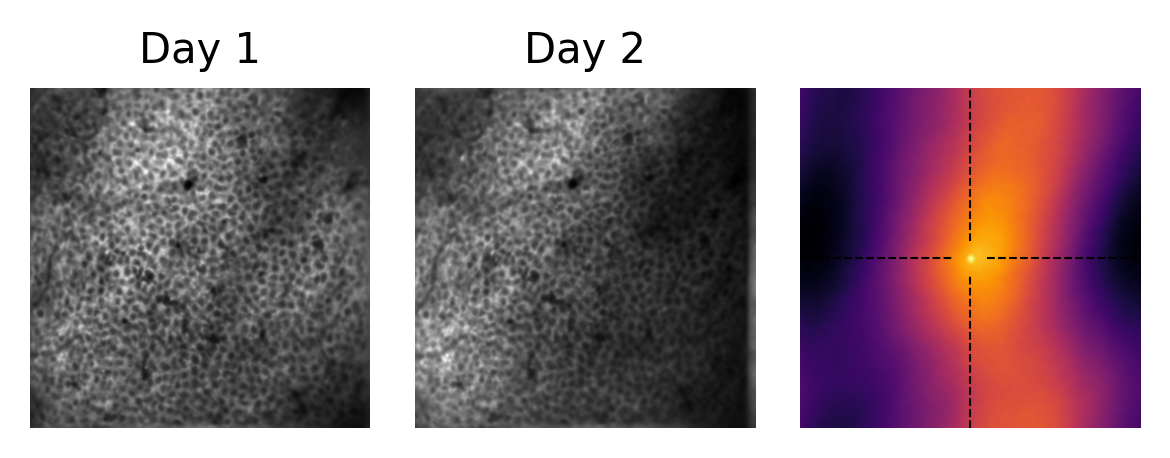

In [9]:
#day 183_03082023
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff/suite2p/plane0')
ops_1 =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops_1 = ops_1.item()

#day 
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_04082023"
processed_datafolder = os.path.join(datafolder, 'UnrotTiff_crossdaymatching/suite2p/plane0')
ops_2 =  np.load(os.path.join(processed_datafolder, 'ops.npy'), allow_pickle=True)
ops_2 = ops_2.item()

meanImg_1 = ops_1['meanImg']
meanImg_2 = ops_2['meanImg']

#pad the smaller one with zeros
constant_values = np.mean(meanImg_1)
if meanImg_1.shape[0] >= meanImg_2.shape[0]:
    #pad meanImg_2 in both width and height
    pad_width = int((meanImg_1.shape[0] - meanImg_2.shape[0])/2)
    meanImg_2_pad = np.pad(meanImg_2, ((pad_width, pad_width), (pad_width, pad_width)), 'constant', constant_values=constant_values)
    meanImg_1_pad = meanImg_1.copy()
elif meanImg_1.shape[0] < meanImg_2.shape[0]:
    #pad meanImg_1 in both width and height
    pad_width = int((meanImg_2.shape[0] - meanImg_1.shape[0])/2)
    meanImg_1_pad = np.pad(meanImg_1, ((pad_width, pad_width), (pad_width, pad_width)), 'constant', constant_values=constant_values)
    meanImg_2_pad = meanImg_2.copy()


#show mean images in gridspec
labelsize = 10
ticksize = 8
fig = plt.figure(figsize=(4,2), dpi=300)

gs = GridSpec(1, 3, width_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0, 0])

ax0.imshow(meanImg_1, cmap='gray')
#ticsk and axis off
ax0.set_xticks([]); ax0.set_yticks([])
ax0.axis('off')
#title
ax0.set_title('Day 1', fontsize=labelsize)


ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(meanImg_2, cmap='gray')
#ticsk and axis off
ax1.set_xticks([]); ax1.set_yticks([])
ax1.axis('off')
#title
ax1.set_title('Day 2', fontsize=labelsize)


#ax2
ax2 = fig.add_subplot(gs[0, 2])
#for meanImg_1 and meanImg_2, center pad the smaller one with zeros to make them the same size
#and then calculate the phase correlation map

#perform phase correlation map of meanImg_1 and meanImg_2
correlation_map = calculate_phase_correlation_map(meanImg_1_pad, meanImg_2_pad)

#show the correlation map
ax2.imshow(correlation_map, cmap='inferno')

#add x=half width and y=half height reference lines as dashed black lines using axhline and axvline
half_width = correlation_map.shape[1]/2
half_height = correlation_map.shape[0]/2

ax2.axhline(y=half_height, xmin=0, xmax=0.45, color='black', linestyle='--', linewidth=0.5)
ax2.axhline(y=half_height, xmin=0.55, xmax=1, color='black', linestyle='--', linewidth=0.5)
ax2.axvline(x=half_width, ymin=0, ymax=0.45, color='black', linestyle='--', linewidth=0.5)
ax2.axvline(x=half_width, ymin=0.55, ymax=1, color='black', linestyle='--', linewidth=0.5)

ax2.set_xticks([half_width]); ax2.set_xticklabels(['0'], size=ticksize)
ax2.set_yticks([half_height]); ax2.set_yticklabels(['0'], size=ticksize)
#axis off
ax2.axis('off')

    
plt.tight_layout()

#save
savefolder = os.path.join(datafolder, 'UnrotTiff_crossdaymatching', '2D2P')
plt.savefig(os.path.join(savefolder, 'crossdaymatching_shiftvalues.pdf'), dpi=300, bbox_inches='tight')